In [7]:
!pip install pandas matplotlib seaborn sklearn tensorflow
!pip install "numpy<2"


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# Load the dataset
file_path = "./proccessedBookings.csv"
df = pd.read_csv(file_path)

# Display basic info
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29990 entries, 0 to 29989
Data columns (total 47 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unnamed: 0.1                               29990 non-null  int64  
 1   Unnamed: 0                                 29509 non-null  float64
 2   name                                       29509 non-null  object 
 3   original_price                             29509 non-null  float64
 4   discounted_price                           29509 non-null  float64
 5   discount                                   29509 non-null  object 
 6   review_score                               29505 non-null  float64
 7   review_title                               28271 non-null  float64
 8   number_of_reviews                          29505 non-null  float64
 9   star_rating                                29202 non-null  float64
 10  is_apartment          

None

,Unnamed: 0.1,Unnamed: 0,name,original_price,discounted_price,discount,review_score,review_title,number_of_reviews,star_rating,...,"neighborhood_Midtown East, New York","neighborhood_Murray Hill, New York",neighborhood_New York,"neighborhood_NoMad, New York","neighborhood_SoHo, New York","neighborhood_Tribeca, New York","neighborhood_Union Square, New York","neighborhood_Upper East Side, New York","neighborhood_Upper West Side, New York","neighborhood_Washington Heights, New York"
0,0,0.0,Iroquois New York Times Square,292.0,218.0,True,8.5,4.0,2625.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,Four Points by Sheraton New York Downtown,130.0,111.0,True,7.8,3.0,1987.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2.0,"The Mayfair Hotel Times Square, Ascend Hotel C...",141.0,141.0,False,8.6,5.0,1895.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3.0,The Washington by LuxUrban,160.0,160.0,False,7.7,3.0,9442.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4.0,Hampton Inn by Hilton New York Times Square,152.0,152.0,False,7.8,3.0,2432.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Feature Engineering
df['log_time_to_travel'] = np.log1p(df['time_to_travel'])  # Log transformation
df['long_stay'] = (df['length_of_stay'] > 3).astype(int)  # 1 if stay > 3 nights, else 0
df['review_score'] = df['review_score'].fillna(df['review_score'].mean()).astype(int)
df['location_score'] = (df['location_score']).fillna(df['review_score'].mean()).astype(int)
df['is_apartment'] = (df['is_apartment']).fillna(df['review_score'].mean()).astype(int)
df['breakfast_included'] = (df['breakfast_included']).fillna(df['review_score'].mean()).astype(int)

In [11]:
room_type_ranking = {
    "King Room": 1,
    "Standard King Room": 2,
    "King Room - Non-Smoking": 3,
    "Queen Room": 4,
    "Double Room": 5,
    "Standard Queen Room": 6,
    "Queen Room - Non-Smoking": 7,
    "Guest Room, 1 King": 8,
    "Deluxe Queen Room": 9,
    "Deluxe King Room": 10,
    "Superior King Room": 11,
    "King Studio": 12,
    "King Room - Disability Access": 13,
    "Superior Queen Room": 14,
    "Standard Room": 15,
    "Queen Studio": 16,
    "Double Room with Two Double Beds": 17,
    "Standard Full": 18,
    "Deluxe King Room - Non-Smoking": 19,
    "Den King Room": 20,
    "Deluxe King": 21,
    "SoHo King": 22,
    "King Room with City View": 23,
    "Standard Double Room": 24,
    "Executive Queen Room": 25
}
df['room_type_grade'] = df['room_type'].map(room_type_ranking).fillna(25).astype(int)

In [12]:
print(df['discounted_price_per_night'].dtype)
print(df['discounted_price_per_night'])

float64
0        218.0
1        111.0
2        141.0
3        160.0
4        152.0
         ...  
29985    285.8
29986    244.4
29987    338.6
29988    317.4
29989    350.0
Name: discounted_price_per_night, Length: 29990, dtype: float64


In [13]:
# Define Features and Target
df_cleaned = df.dropna(subset=['log_time_to_travel', 'length_of_stay', 'long_stay', 'discounted_price_per_night','review_score','number_of_reviews', 'location_score','is_apartment','breakfast_included','room_type_grade'])
X = df_cleaned[['log_time_to_travel', 'length_of_stay', 'long_stay', 'discounted_price_per_night','review_score','number_of_reviews', 'location_score','is_apartment','breakfast_included','room_type_grade']]  # Features
y = df_cleaned['discounted_price_per_night']  # Target Variable

In [14]:
print(X.shape)
print(y.shape)
print(X.head())  # Check if X contains valid data
print(y.head())  # Check if y contains valid target values

(29505, 10)
(29505,)
   log_time_to_travel  length_of_stay  long_stay  discounted_price_per_night  \
0            0.693147             1.0          0                       218.0   
1            0.693147             1.0          0                       111.0   
2            0.693147             1.0          0                       141.0   
3            0.693147             1.0          0                       160.0   
4            0.693147             1.0          0                       152.0   

   review_score  number_of_reviews  location_score  is_apartment  \
0             8             2625.0               9             0   
1             7             1987.0               7             0   
2             8             1895.0               9             0   
3             7             9442.0               9             0   
4             7             2432.0               9             0   

   breakfast_included  room_type_grade  
0                   1               25  
1      

In [15]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
# Train Multiple Regression Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Gaussian Process': GaussianProcessRegressor(kernel=C(1.0) * RBF(1.0)),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'SVR': SVR(kernel='rbf')
}

In [18]:
nan_vals = np.isnan(y_train).sum()
print(f"Number of NaN values in X_train_scaled: {nan_vals}")

Number of NaN values in X_train_scaled: 0


In [19]:
# Train and Evaluate Models
results = {}
for name, model in models.items():
     model.fit(X_train_scaled, y_train)
     y_pred = model.predict(X_test_scaled)
     results[name] = {
          'R2': r2_score(y_test, y_pred),
          
          'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
     }

In [20]:
# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


                         R2           MAE           MSE          RMSE
Linear Regression  1.000000  1.054705e-13  1.745736e-26  1.321263e-13
Decision Tree      0.996413  3.077026e+00  2.322320e+01  4.819046e+00
Gaussian Process   0.966325  1.055468e+00  2.180498e+02  1.476651e+01
Random Forest      0.998168  2.062979e+00  1.185924e+01  3.443724e+00
Gradient Boosting  0.999864  5.686503e-01  8.837373e-01  9.400730e-01
SVR                0.929071  5.916356e+00  4.592674e+02  2.143053e+01


In [21]:
# Plot Residuals for Best Model (Based on R² Score)
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

C:\Users\Ilai\AppData\Local\Temp/ipykernel_32176/1404117669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


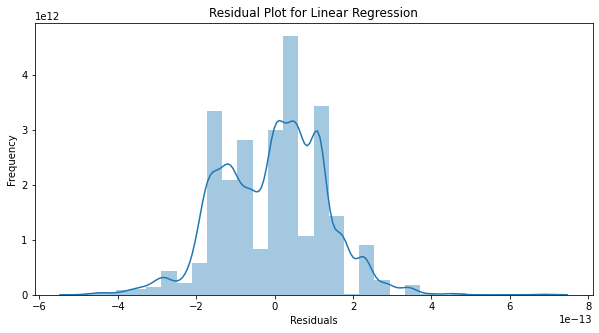

In [22]:
plt.figure(figsize=(10, 5))
sns.distplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



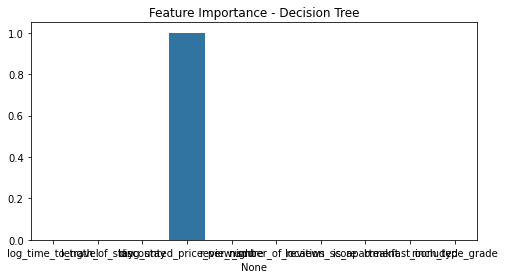

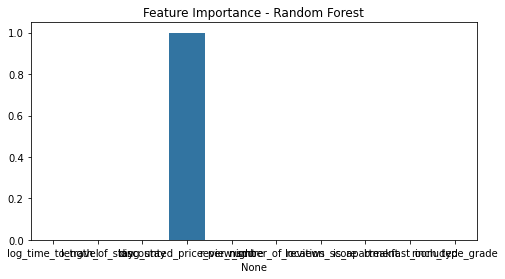

In [23]:
# Feature Importance for Decision Tree and Random Forest
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    feature_importance = model.feature_importances_
    plt.figure(figsize=(8, 4))
    sns.barplot(x=X.columns, y=feature_importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

In [24]:
# Neural Network Model 1
nn_model_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
nn_model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model_1.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=0)

c:\Users\Ilai\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Neural Network Model 2 with Embedding
embedding_dim = 5
input_layer = layers.Input(shape=(X_train_scaled.shape[1],))
embedding_layer = layers.Dense(embedding_dim, activation='relu')(input_layer)
hidden_layer = layers.Dense(32, activation='relu')(embedding_layer)
output_layer = layers.Dense(1)(hidden_layer)
nn_model_2 = keras.Model(inputs=input_layer, outputs=output_layer)
nn_model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model_2.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=0)